In [1]:
print('hello world')

hello world


In [2]:
!pip install numpy

In [3]:
!pip install networkx
!pip install matplotlib
!pip install pydantic

In [4]:
!pip install pandas

In [5]:
!pip install openpyxl


In [6]:
from pydantic import BaseModel, ConfigDict, Field
import pandas as pd
import datetime


class Workstation(BaseModel):
    name: str
    max_units_per_run: int
    minutes_per_run: float
    minutes_changeover_time_taste: int
    minutes_changeover_time_bottle_size: int
    starts_at: datetime.time
    stops_at: datetime.time


class Product(BaseModel):
    product_id: int
    product_name: str
    setting_taste: str
    setting_bottle_size: str | None
    workstation_type: str


class BillOfMaterial(BaseModel):
    parent_id: int
    parent_name: str
    component_id: int
    component_name: str
    component_quantity: float


class ProductionOrder(BaseModel):
    production_order_nr: str
    days_till_delivery: int
    product_id: int
    amount: int
    liters_required: float = Field(alias="liters required")
    minutes_bottling_time: float = Field(alias="Bottling time in minutes")


class Data(BaseModel):
    """Contains all the data needed for the production scheduling problem."""

    model_config = ConfigDict(arbitrary_types_allowed=True)

    workstations: list[Workstation]
    products: dict[int, Product]
    bill_of_materials: dict[int, BillOfMaterial]
    production_orders: list[ProductionOrder]
    workstation_df: pd.DataFrame
    products_df: pd.DataFrame
    bill_of_materials_df: pd.DataFrame
    production_orders_df: pd.DataFrame


def parse_data(path: str) -> Data:
    workstations_df = pd.read_excel(path, sheet_name="workstations").replace(
        pd.NA, None
    )
    products_df = pd.read_excel(path, sheet_name="products").replace(pd.NA, None)
    bill_of_materials_df = pd.read_excel(path, sheet_name="bill of materials").replace(
        pd.NA, None
    )
    production_orders_df = pd.read_excel(path, sheet_name="production orders").replace(
        pd.NA, None
    )

    workstations = [
        Workstation(**workstation)  # type: ignore
        for workstation in workstations_df.to_dict("records")
    ]
    products = {
        product["product_id"]: Product(**product)
        for product in products_df.to_dict("records")
    }  # type: ignore
    bill_of_materials = {
        bom["parent_id"]: BillOfMaterial(**bom)  # type: ignore
        for bom in bill_of_materials_df.to_dict("records")
    }
    production_orders = [
        ProductionOrder(**order)  # type: ignore
        for order in production_orders_df.to_dict("records")
    ]
    return Data(
        workstations=workstations,
        products=products,
        bill_of_materials=bill_of_materials,
        production_orders=production_orders,
        workstation_df=workstations_df,
        products_df=products_df,
        bill_of_materials_df=bill_of_materials_df,
        production_orders_df=production_orders_df,
    )


if __name__ == "__main__":
    data = parse_data(r"C:\Users\julia\OneDrive\Documents\GitHub\bachelors-thesis\src\examples\data_v1.xlsx")
    print(data)


workstations=[Workstation(name='Mixing line 1', max_units_per_run=4000, minutes_per_run=60.0, minutes_changeover_time_taste=15, minutes_changeover_time_bottle_size=0, starts_at=datetime.time(6, 0), stops_at=datetime.time(20, 0)), Workstation(name='Bottling line 1', max_units_per_run=1, minutes_per_run=0.06, minutes_changeover_time_taste=10, minutes_changeover_time_bottle_size=20, starts_at=datetime.time(6, 0), stops_at=datetime.time(21, 0)), Workstation(name='Bottling line 2', max_units_per_run=1, minutes_per_run=0.06, minutes_changeover_time_taste=10, minutes_changeover_time_bottle_size=20, starts_at=datetime.time(6, 0), stops_at=datetime.time(23, 0))] products={0: Product(product_id=0, product_name='hf cola', setting_taste='cola', setting_bottle_size=None, workstation_type='mix'), 1: Product(product_id=1, product_name='hf fanta', setting_taste='fanta', setting_bottle_size=None, workstation_type='mix'), 2: Product(product_id=2, product_name='hf orange juice', setting_taste='orange jui

In [97]:
from enum import Enum
from typing import Any, List, Tuple, Dict, Self
import numpy as np
from pydantic import BaseModel
#from src.production_orders import Data, Product, BillOfMaterial
import networkx as nx
import matplotlib.pyplot as plt

DAY_MINUTES = 24 * 60


class Job(BaseModel):
    available_machines: dict[int, float]
    dependencies: list[int]
    production_order_nr: str
    station_settings: dict[str, Any] = dict()
    amount: int = 1
    days_till_delivery: int = 0
    used: float = 0.0


class Machine(BaseModel):
    name: str
    machine_id: int
    start_time: int = 0
    end_time: int
    allow_preemption: bool = False
    max_units_per_run: int = 1
    minutes_per_run: float


class ScheduleError(Exception): ...


schedule_type = dict[int, list[tuple[int, int, int]]]


class JobShopProblem:
    LOW_TARDINESS = None
    LOW_TOTAL_SETUP_TIME = None
    LOW_MAKESPAN = None

    def __init__(self, data: Data, jobs: list[Job], machines: list[Machine]) -> None:
        self.data: Data = data
        self.jobs: list[Job] = jobs
        self.machines: list[Machine] = machines
        self.setup_times: np.ndarray = np.zeros((len(jobs), len(jobs)))
        self.graph = self._build_graph()
        self.bottle_size_mapping: dict[str, float] = {
            product.setting_bottle_size: data.bill_of_materials[
                product.product_id
            ].component_quantity
            if product.setting_bottle_size
            else 1.0
            for product in data.products.values()
            if product.setting_bottle_size
        }

    def _build_graph(self) -> nx.DiGraph:
        graph = nx.DiGraph()
        graph.add_nodes_from([-1, -2] + [x for x in range(len(self.jobs))])
        edges = list()
        for job_idx, job in enumerate(self.jobs):
            if len(job.dependencies) == 0:
                edges.append((-1, job_idx))
                continue
            for dep in job.dependencies:
                edges.append((dep, job_idx))
        graph.add_edges_from(edges)
        for node, outdegree in graph.out_degree(graph.nodes()):
            if outdegree == 0 and node >= 0:
                graph.add_edge(node, -2)
        return graph

    def visualize_schedule(
        self,
        schedule: dict[int, list[tuple[int, int, int]]],
        save_path: str | None = None,
    ):
        """Visualizes a schedule."""
        fig, ax = plt.subplots(figsize=(13, 7))
        cmap = plt.get_cmap("tab20")
        for i, (machine, sch) in enumerate(schedule.items()):
            for idx, task in enumerate(sch):
                job_id, start_time, end_time = task
                if job_id == -1:
                    continue
                setup_time = self.setup_times[sch[idx - 1][0], job_id]
                # Check if we have a preemption job
                plot_times = [(start_time, end_time, setup_time)]
                if (
                    end_time - start_time - setup_time
                    > self.jobs[job_id].available_machines[machine]
                ):
                    plot_times = [
                        (
                            start_time,
                            self.machines[machine].end_time
                            + 24 * 60 * (start_time // (24 * 60)),
                            setup_time,
                        ),
                        (
                            self.machines[machine].start_time
                            + 24 * 60 * (end_time // (24 * 60)),
                            end_time,
                            0,
                        ),
                    ]
                for start_time, end_time, setup_time in plot_times:
                    ax.plot(
                        [start_time + setup_time, end_time],
                        [i + 1, i + 1],
                        linewidth=50,
                        label=self.jobs[job_id].production_order_nr,
                        solid_capstyle="butt",
                        color=cmap(
                            int(self.jobs[job_id].production_order_nr.removeprefix("P"))
                        ),
                    )
                    ax.plot(
                        [start_time, start_time + setup_time],
                        [i + 1, i + 1],
                        linewidth=50,
                        solid_capstyle="butt",
                        color=cmap(
                            int(self.jobs[job_id].production_order_nr.removeprefix("P"))
                        ),
                        alpha=0.5,
                    )
                    color = "black"
                    if end_time - self.jobs[job_id].days_till_delivery * 24 * 60 > 0:
                        color = "red"

                    ax.text(
                        (start_time + end_time) / 2,
                        i + 1,
                        self.jobs[job_id].production_order_nr,  # + f" ({job_id})",
                        va="center",
                        ha="right",
                        fontsize=11,
                        color=color,
                    )
        flat_schedule = list()
        for val in schedule.values():
            flat_schedule.extend(val)
        max_time = max([t[2] for t in flat_schedule])

        day_markers = np.arange(0, max_time, 24 * 60)
        day_labels = [f"{d//24//60}" for d in day_markers]

        # plt.xticks(ticks=np.concatenate([day_markers]), labels=day_labels)
        plt.yticks(
            ticks=np.arange(1, len(schedule) + 1),
            labels=[str(self.machines[m].name) for m in schedule.keys()],
        )
        plt.xlabel("Days")
        plt.ylabel("Machine")
        plt.tight_layout()

        for machine in self.machines:
            x_lines_start = np.arange(machine.start_time, max_time, 24 * 60)
            plt.vlines(
                x_lines_start,
                machine.machine_id + 0.5,
                machine.machine_id + 1.5,
                linestyles="dashed",
                color="green",
            )
            x_lines_end = np.arange(machine.end_time, max_time, 24 * 60)
            plt.vlines(
                x_lines_end,
                machine.machine_id + 0.5,
                machine.machine_id + 1.5,
                linestyles="dashed",
                color="red",
            )

        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()
    @classmethod
    def from_data(cls, data: Data) -> Self:
        """Generate a JobShopProblem from the data provided according to the excel sheet.

        Args:
            data (Data): The data that is parsed from the excel sheet.

        Returns:
            Self: The JobShopProblem object.
        """
        sub_jobs: list[Job] = list()
        machines: list[Machine] = [
            Machine(
                name=m.name,
                machine_id=idx,
                start_time=m.starts_at.hour * 60 + m.starts_at.minute,
                end_time=m.stops_at.hour * 60 + m.stops_at.minute,
                allow_preemption=(m.name.lower().startswith("bottling")),
                max_units_per_run=m.max_units_per_run,
                minutes_per_run=m.minutes_per_run,
            )
            for idx, m in enumerate(data.workstations)
        ]
        for order in data.production_orders:
            # We collect all the products we need to produce
            # 1. We get the final product from the products table
            # 2. We look in the bill of materials to see if that product has any sub products that are needed
            # 3. If it has, we add the sub product from the products table and repeat step 2.
            products = list()
            curent_product = order.product_id
            while curent_product is not None:
                product = data.products[curent_product]
                bill_of_materials = data.bill_of_materials.get(curent_product, None)
                products.append((product, bill_of_materials))
                if bill_of_materials:
                    curent_product = bill_of_materials.component_id
                else:
                    curent_product = None
            # We reverse the products list, because the products have to be produced in sequential order
            products: list[tuple[Product, BillOfMaterial | None]] = products[::-1]
            # We split the job into batches of the same product
            product_info = list()
            # NOTE: amount is different from the amount in the job, since we calcualte the
            # amount based on what unit the machine can process
            for idx, (prod, _) in enumerate(products):
                prod_info = dict()
                if idx + 1 < len(products):
                    bom = products[idx + 1][1]
                else:
                    bom = None
                amount = order.amount * bom.component_quantity if bom else order.amount
                prod_info["amount"] = amount
                # HACK: we are shortening the name by 1 since it says bottle and not bottling, which the machine name is
                prod_info["machines"] = [
                    m.machine_id
                    for m in machines
                    if m.name.lower().startswith(prod.workstation_type[:-1])
                ]
                # HACK: the batch sizes are not calculated per machine, so if two machines
                # that process the same job has different ones, we will take the one that has
                # the lowest capacity to calculate the batch size
                min_max_units_per_run = min(
                    [machines[m].max_units_per_run for m in prod_info["machines"]]
                )
                batches = np.ceil(amount / min_max_units_per_run)
                prod_info["batches"] = int(batches)
                prod_info["batches_amount"] = min_max_units_per_run
                remainder = int(amount % min_max_units_per_run)
                prod_info["batches_remainder"] = (
                    remainder if remainder > 0 else min_max_units_per_run
                )
                product_info.append(prod_info)
            # We calculate the correct batch size, or in other words the job that has
            # the smallest batch amount size, since that will be the bottle neck.
            # However, we ignore if the jobs can be run independently, since we will just make that into
            # one batch
            batch_info = min(
                product_info,
                key=lambda x: x["batches_amount"] if x["batches_amount"] > 1 else 10e4,
            )
            for i in range(batch_info["batches"]):
                for idx, prod in enumerate(product_info):
                    dependencies = list()
                    if idx > 0:
                        dependencies.append(len(sub_jobs) - 1)

                    amount = prod["amount"] // batch_info["batches"]

                    if i == batch_info["batches"] - 1 and batch_info["batches"] > 1:
                        amount = prod["amount"] % ((batch_info["batches"] - 1) * amount)
                        if amount == 0:
                            amount = prod["amount"] // batch_info["batches"]
                    amount = np.ceil(amount)
                    sub_jobs.append(
                        Job(
                            available_machines={
                                m: data.workstations[m].minutes_per_run * amount
                                if data.workstations[m].max_units_per_run == 1
                                else data.workstations[m].minutes_per_run
                                for m in prod["machines"]
                            },
                            dependencies=dependencies,
                            production_order_nr=order.production_order_nr,
                            station_settings={
                                "taste": products[idx][0].setting_taste,
                                "bottle_size": products[idx][0].setting_bottle_size,  # type: ignore
                            },
                            amount=amount,
                            days_till_delivery=order.days_till_delivery,
                        )
                    )
        jssp = cls(data=data, jobs=sub_jobs, machines=machines)

        # Set setup-times
        for j1_idx, j1 in enumerate(jssp.jobs):
            for j2_idx, j2 in enumerate(jssp.jobs):
                if j1 == j2 or j1.production_order_nr == j2.production_order_nr:
                    continue
                if j1.station_settings["taste"] != j2.station_settings["taste"]:
                    jssp.setup_times[j1_idx, j2_idx] += jssp.data.workstations[
                        list(j1.available_machines.keys())[0]
                    ].minutes_changeover_time_taste

                if (
                    j1.station_settings["bottle_size"]
                    != j2.station_settings["bottle_size"]
                ):
                    jssp.setup_times[j1_idx, j2_idx] += jssp.data.workstations[
                        list(j1.available_machines.keys())[0]
                    ].minutes_changeover_time_bottle_size

        return jssp

    def make_schedule(self, job_order: list[int], machine_assignment: list[int]) -> schedule_type:
        """Create a schedule based on a given job order and machine assignment."""
        schedule: dict[int, list[tuple[int, int, int]]] = {
            m.machine_id: [(-1, 0, m.start_time)] for m in self.machines
        }

        job_schedule: dict[int, tuple[int, int, int]] = dict()

        for task_idx in job_order:
            task: Job = self.jobs[task_idx]
            machine_idx = machine_assignment[task_idx]
            if machine_idx not in task.available_machines:
                raise ScheduleError(
                    f"Machine {machine_idx} not available for task {task_idx}"
                )
            machine = self.machines[machine_idx]

            relevant_task: list[tuple[int, int, int]] = list()

            # Get the last job on the same machine
            latest_job_on_same_machine = schedule[machine_idx][-1]
            relevant_task.append(latest_job_on_same_machine)

            # Check for dependencies
            #if len(task.dependencies) > 0:
             #   for dep in task.dependencies:
              ##         relevant_task.append(dep_task)
                #    else:
                 ##      raise ScheduleError(
                   #         f"Dependency {dep} not scheduled before {task_idx}"
                      #  )

            # Get the start time of the task
            start_time = max([task[2] for task in relevant_task])

            task_duration: int = int(
                task.available_machines[machine_idx]
                + self.setup_times[latest_job_on_same_machine[0], task_idx]
            )
            # If task is scheduled before the machine starts, we move it to the start time
            if start_time % DAY_MINUTES < machine.start_time:
                start_time = (
                    machine.start_time + (start_time // DAY_MINUTES) * DAY_MINUTES
                )

            # If the task ends after the machine stops, we move it to the next day, unless we allow preemption.
            if start_time % DAY_MINUTES + task_duration > machine.end_time:
                if machine.allow_preemption:
                    task_duration += DAY_MINUTES - machine.end_time + machine.start_time
                else:
                    start_time = (
                        machine.start_time
                        + (start_time // DAY_MINUTES + 1) * DAY_MINUTES
                    )

            end_time = start_time + task_duration
            schedule[machine_idx].append((task_idx, start_time, end_time))
            job_schedule[task_idx] = (machine_idx, start_time, end_time)

        return schedule


    def make_schedule_from_parallel(self, job_orders: list[list[int]]) -> schedule_type:
        schedule: dict[int, list[tuple[int, int, int]]] = {
            m.machine_id: [(-1, 0, m.start_time)] for m in self.machines
        }
        job_schedule: dict[int, tuple[int, int, int]] = dict()
        for machine in self.machines:
            machine_idx = machine.machine_id
            for task_idx in job_orders[machine_idx]:
                if task_idx == -1:
                    continue
                task: Job = self.jobs[task_idx]
                if machine_idx not in task.available_machines:
                    raise ScheduleError(
                        f"Machine {machine_idx} not available for task {task_idx}"
                    )
                machine = self.machines[machine_idx]

                relevant_task: list[tuple[int, int, int]] = list()

                # Get the last job on the same machine
                latest_job_on_same_machine = schedule[machine_idx][-1]
                relevant_task.append(latest_job_on_same_machine)

                # Check for dependencies
                if len(task.dependencies) > 0:
                    for dep in task.dependencies:
                        if dep_task := job_schedule.get(dep, None):
                            relevant_task.append(dep_task)
                        else:
                            raise ScheduleError(
                                f"Dependency {dep} not scheduled before {task_idx}"
                            )

                # Get the start time of the task
                start_time = max([task[2] for task in relevant_task])

                task_duration: int = int(
                    task.available_machines[machine_idx]
                    + self.setup_times[latest_job_on_same_machine[0], task_idx]
                )
                # If task is schedule before the machine starts, we move it to the start time
                if start_time % DAY_MINUTES < machine.start_time:
                    start_time = (
                        machine.start_time + (start_time // DAY_MINUTES) * DAY_MINUTES
                    )

                # If the task ends after the machine stops, we move it to the next day, unless we allow preemption.
                # If we allow preemption we will just continue with the work the next day
                if start_time % DAY_MINUTES + task_duration > machine.end_time:
                    # If we allow for preemption we will just add to the duration the time inbetween start and end time
                    if machine.allow_preemption:
                        task_duration += (
                            DAY_MINUTES - machine.end_time + machine.start_time
                        )
                    else:
                        start_time = (
                            machine.start_time
                            + (start_time // DAY_MINUTES + 1) * DAY_MINUTES
                        )

                end_time = start_time + task_duration
                schedule[machine_idx].append((task_idx, start_time, end_time))
                job_schedule[task_idx] = (machine_idx, start_time, end_time)

        return schedule

    def make_schedule_from_parallel_with_stock(
        self, job_orders: list[list[int]]
    ) -> schedule_type:
        schedule: dict[int, list[tuple[int, int, int]]] = {
            m.machine_id: [(-1, 0, m.start_time)] for m in self.machines
        }
        # job_schedule: dict[int, tuple[int, int, int]] = dict()
        mixing_machines = [
            m for m in self.machines if m.name.lower().startswith("mixing")
        ]
        for m in mixing_machines:
            machine_idx = m.machine_id
            for task_idx in job_orders[machine_idx]:
                if task_idx == -1:
                    continue
                task: Job = self.jobs[task_idx]
                task.used = 0.0
                if machine_idx not in task.available_machines:
                    raise ScheduleError(
                        f"Machine {machine_idx} not available for task {task_idx}"
                    )
                machine = self.machines[machine_idx]

                relevant_task: list[tuple[int, int, int]] = list()

                # Get the last job on the same machine
                latest_job_on_same_machine = schedule[machine_idx][-1]
                start_time = latest_job_on_same_machine[2]
                task_duration: int = int(
                    task.available_machines[machine_idx]
                    + self.setup_times[latest_job_on_same_machine[0], task_idx]
                )
                # If task is schedule before the machine starts, we move it to the start time
                if start_time % DAY_MINUTES < machine.start_time:
                    start_time = (
                        machine.start_time + (start_time // DAY_MINUTES) * DAY_MINUTES
                    )

                # If the task ends after the machine stops, we move it to the next day, unless we allow preemption.
                # If we allow preemption we will just continue with the work the next day
                if start_time % DAY_MINUTES + task_duration > machine.end_time:
                    # If we allow for preemption we will just add to the duration the time inbetween start and end time
                    if machine.allow_preemption:
                        task_duration += (
                            DAY_MINUTES - machine.end_time + machine.start_time
                        )
                    else:
                        start_time = (
                            machine.start_time
                            + (start_time // DAY_MINUTES + 1) * DAY_MINUTES
                        )

                end_time = start_time + task_duration
                schedule[machine_idx].append((task_idx, start_time, end_time))
                # job_schedule[task_idx] = (machine_idx, start_time, end_time)

        # Handle the bottling machines
        jobs_left_per_machine = {
            m.machine_id: 0
            for m in self.machines
            if m.name.lower().startswith("bottling")
        }
        while True:
            if all([v == len(job_orders[m]) for m, v in jobs_left_per_machine.items()]):
                break
            for machine_idx in jobs_left_per_machine:
                if jobs_left_per_machine[machine_idx] == len(job_orders[machine_idx]):
                    continue
                machine = self.machines[machine_idx]
                task_idx = job_orders[machine_idx][jobs_left_per_machine[machine_idx]]
                if task_idx == -1:
                    jobs_left_per_machine[machine_idx] += 1
                    continue
                task: Job = self.jobs[task_idx]
                if machine_idx not in task.available_machines:
                    raise ScheduleError(
                        f"Machine {machine_idx} not available for task {task_idx}"
                    )
                machine = self.machines[machine_idx]

                relevant_task: list[tuple[int, int, int]] = list()

                # Get the last job on the same machine
                latest_job_on_same_machine = schedule[machine_idx][-1]
                relevant_task.append(latest_job_on_same_machine)

                if self.machines[machine_idx].name.lower().startswith("bottl"):
                    amount_needed = (
                        task.amount
                        * self.bottle_size_mapping[task.station_settings["bottle_size"]]
                    )
                    # Look for the mixing machines and see from which we can tak
                    take_from: dict[int, list[tuple[float, int, int]]] = {
                        m.machine_id: [(0.0, -1, 0)] for m in mixing_machines
                    }
                    for mix_machine in mixing_machines:
                        mix_machine_sum = 0.0
                        mix_machine_schedule = schedule[mix_machine.machine_id]
                        for mix_task_idx in mix_machine_schedule:
                            if mix_task_idx[0] == -1:
                                continue
                            mix_task = self.jobs[mix_task_idx[0]]
                            if (
                                mix_task.station_settings["taste"]
                                == task.station_settings["taste"]
                            ):
                                to_use = min(
                                    amount_needed - mix_machine_sum,
                                    mix_task.amount - mix_task.used,
                                )
                                mix_machine_sum += to_use
                                take_from[mix_machine.machine_id].append(
                                    (to_use, mix_task_idx[0], mix_task_idx[2])
                                )
                            if mix_machine_sum >= amount_needed:
                                break
                    # Take from the mixing machine which has the lowest finish time
                    take_from_machine = min(
                        take_from, key=lambda x: take_from[x][-1][1]
                    )
                    for tsk in take_from[take_from_machine]:
                        if tsk[1] == -1:
                            continue
                        # Update the used amount
                        self.jobs[tsk[1]].used += tsk[0]
                        # Update the relevant tasks
                        relevant_task.append((tsk[1], 0, tsk[2]))

                # Get the start time of the task
                start_time = max([task[2] for task in relevant_task])

                task_duration: int = int(
                    task.available_machines[machine_idx]
                    + self.setup_times[latest_job_on_same_machine[0], task_idx]
                )
                # If task is schedule before the machine starts, we move it to the start time
                if start_time % DAY_MINUTES < machine.start_time:
                    start_time = (
                        machine.start_time + (start_time // DAY_MINUTES) * DAY_MINUTES
                    )

                # If the task ends after the machine stops, we move it to the next day, unless we allow preemption.
                # If we allow preemption we will just continue with the work the next day
                if start_time % DAY_MINUTES + task_duration > machine.end_time:
                    # If we allow for preemption we will just add to the duration the time inbetween start and end time
                    if machine.allow_preemption:
                        task_duration += (
                            DAY_MINUTES - machine.end_time + machine.start_time
                        )
                    else:
                        start_time = (
                            machine.start_time
                            + (start_time // DAY_MINUTES + 1) * DAY_MINUTES
                        )

                end_time = start_time + task_duration
                schedule[machine_idx].append((task_idx, start_time, end_time))
                jobs_left_per_machine[machine_idx] += 1
                # job_schedule[task_idx] = (machine_idx, start_time, end_time)
        return schedule

    def makespan(self, schedule: schedule_type) -> int:
        """Calculate the makespan of the schedule.

        Args:
            schedule (schedule): the schedule that should be evaluated

        Returns:
            int: the makespan of the schedule
        """
        return max([task[2] for machine in schedule.values() for task in machine])

    def tardiness(self, schedule: schedule_type) -> int:
        """Calculate the tardiness of the schedule. The tardiness is the number of sub jobs that are late.

        As soon as just 1 sub job is late the whole order is late, and should be penalized.

        Args:
            schedule (schedule): the schedule that should be evaluated

        Returns:
            int: the tardiness of the schedule
        """
        production_order_lateness = {
            order.production_order_nr: [] for order in self.data.production_orders
        }
        for machine in schedule.values():
            for task in machine:
                production_order_lateness[
                    self.jobs[task[0]].production_order_nr
                ].append(
                    max(
                        task[2] - self.jobs[task[0]].days_till_delivery * DAY_MINUTES, 0
                    )
                )

        tardiness = 0
        for lateness in production_order_lateness.values():
            if any([l > 0 for l in lateness]):
                tardiness += np.average(lateness) * len(lateness)
        return int(tardiness)

    def total_setup_time(self, schedule: schedule_type) -> int:
        """Calculate the total setup time of the schedule.

        Args:
            schedule (schedule): the schedule that should be evaluated

        Returns:
            int: the total setup time of the schedule
        """
        setup_time = 0
        for machine in schedule.values():
            for idx, task in enumerate(machine):
                if idx > 0:
                    setup_time += self.setup_times[machine[idx - 1][0], task[0]]
        return setup_time

    def custom_objective(self, schedule: schedule_type) -> float:
        tardiness = self.boolean_tardiness(schedule)
        total_setup_time = self.total_setup_time(schedule)
        makespan = self.makespan(schedule)
        if self.LOW_TARDINESS is None:
            self.LOW_TARDINESS = 16.0
        if self.LOW_TOTAL_SETUP_TIME is None:
            self.LOW_TOTAL_SETUP_TIME = 100.0
        if self.LOW_MAKESPAN is None:
            self.LOW_MAKESPAN = 3000.0

        return (
            (tardiness - self.LOW_TARDINESS) / self.LOW_TARDINESS
            + (total_setup_time - self.LOW_TOTAL_SETUP_TIME) / self.LOW_TOTAL_SETUP_TIME
            + (makespan - self.LOW_MAKESPAN) / self.LOW_MAKESPAN
        )

    def boolean_tardiness(self, schedule: schedule_type) -> int:
        production_order_lateness = {
            order.production_order_nr: [] for order in self.data.production_orders
        }
        for machine in schedule.values():
            for task in machine:
                production_order_lateness[
                    self.jobs[task[0]].production_order_nr
                ].append(
                    max(
                        task[2] - self.jobs[task[0]].days_till_delivery * DAY_MINUTES, 0
                    )
                )

        tardiness = 0
        for lateness in production_order_lateness.values():
            if any([l > 0 for l in lateness]):
                tardiness += (max(lateness) / DAY_MINUTES) * len(lateness)
        return int(tardiness)

class ObjectiveFunction(Enum):
    CUSTOM_OBJECTIVE = 0
    MAKESPAN = 1
    TARDINESS = 2
    TOTAL_SETUP_TIME = 3
    BOOLEAN_TARDINESS = 4

In [100]:
#from enum import Enum
#import numpy as np
from pydantic import BaseModel
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque, defaultdict

class TabuSearchScheduler:
    def __init__(self, job_shop_problem: JobShopProblem, tabu_tenure: int = 10):
        self.problem = job_shop_problem
        self.tabu_tenure = tabu_tenure
        self.tabu_list: Dict[Tuple[int, int, int, int], int] = {}
        self.best_solution = None
        self.best_objective_value = float('inf')
        self.current_solution = None
        self.current_objective_value = float('inf')
        self.iteration = 0

    def topological_sort(self):
        in_degree = defaultdict(int)
        graph = defaultdict(list)
        
        # Build the graph and compute in-degrees
        for job_idx, job in enumerate(self.problem.jobs):
            for dep in job.dependencies:
                graph[dep].append(job_idx)
                in_degree[job_idx] += 1

        # Queue of jobs with no dependencies
        queue = deque([job_idx for job_idx in range(len(self.problem.jobs)) if in_degree[job_idx] == 0])
        sorted_jobs = []

        while queue:
            job_idx = queue.popleft()
            sorted_jobs.append(job_idx)
            for neighbor in graph[job_idx]:
                in_degree[neighbor] -= 1
                if in_degree[neighbor] == 0:
                    queue.append(neighbor)

        if len(sorted_jobs) != len(self.problem.jobs):
            raise ScheduleError("Circular dependency detected")

        return sorted_jobs

    def assign_machine(self, job: Job) -> int:
        # Assign job to the first available machine that matches its type
        for machine_id in job.available_machines:
            machine = self.problem.machines[machine_id]
            print(f"Trying to assign job {job.production_order_nr} to machine {machine.name}")
            print(f"Machine type: {'Mixing' if machine.name.startswith('Mixing') else 'Bottling'}")
            if machine.name.startswith('Mixing') and job.station_settings.get('taste').capitalize() in ['Cola', 'Fanta']:
                return machine_id
            if machine.name.startswith('Bottling') and (job.station_settings.get('bottle_size') in ['0.5L', '250ml', '200ml', '1L', '1.5L', '2L'] or job.station_settings.get('bottle_size') is None):
                return machine_id
        print(f"Failed to assign job {job.production_order_nr} with settings {job.station_settings}")
        raise ScheduleError(f"No available machine for job {job.production_order_nr}")

    def generate_initial_solution(self):
        job_order = self.topological_sort()
        print("Job Order:", job_order)

        # Convert job_order into a matrix format suitable for make_schedule_from_parallel hhh
        job_orders = [[] for _ in range(len(self.problem.machines))]
        
        for job_idx in job_order:
            job = self.problem.jobs[job_idx]
            print(f"Job {job.production_order_nr}: taste={job.station_settings.get('taste')}, bottle_size={job.station_settings.get('bottle_size')}")
            print("Available machines and their capabilities:")
            
            for machine_id in job.available_machines:
                machine = self.problem.machines[machine_id]
                print(f"  Machine {machine.name}: starts_at={machine.start_time}, ends_at={machine.end_time}, type={('Mixing' if machine.name.startswith('Mixing') else 'Bottling')}")
            
            machine_idx = self.assign_machine(job)
            job_orders[machine_idx].append(job_idx)

        print("Initial Job Orders:", job_orders)
        self.current_solution = job_orders
        self.current_objective_value = self.problem.custom_objective(
            self.problem.make_schedule_from_parallel_with_stock(job_orders)
        )
        self.best_solution = self.current_solution
        self.best_objective_value = self.current_objective_value

    def update_tabu_list(self, move: Tuple[int, int, int, int]):
        self.tabu_list[move] = self.iteration + self.tabu_tenure

    def is_tabu(self, move: Tuple[int, int, int, int]) -> bool:
        return move in self.tabu_list and self.tabu_list[move] > self.iteration

    def aspiration_criteria(self, objective_value: float) -> bool:
        return objective_value < self.best_objective_value

    def generate_neighbors(self) -> List[Tuple[List[List[int]], Tuple[int, int, int, int]]]:
        neighbors = []
        job_orders = [list(machine_jobs) for machine_jobs in self.current_solution]

        for machine_idx, jobs in enumerate(job_orders):
            for i in range(len(jobs)):
                for j in range(i + 1, len(jobs)):
                    new_job_orders = [list(machine_jobs) for machine_jobs in job_orders]
                    new_job_orders[machine_idx][i], new_job_orders[machine_idx][j] = new_job_orders[machine_idx][j], new_job_orders[machine_idx][i]

                    try:
                        neighbor_solution = self.problem.make_schedule_from_parallel_with_stock(new_job_orders)
                        neighbors.append((new_job_orders, (machine_idx, i, machine_idx, j)))  # Include the move representation
                    except ScheduleError:
                        continue

        return neighbors

    def neighborhood_search(self):
        neighbors = self.generate_neighbors()
        best_neighbor = None
        best_neighbor_value = float('inf')

        for neighbor in neighbors:
            move = neighbor[1]  # Example move representation
            if not self.is_tabu(move) or self.aspiration_criteria(self.problem.custom_objective(self.problem.make_schedule_from_parallel_with_stock(neighbor[0]))):
                neighbor_value = self.problem.custom_objective(self.problem.make_schedule_from_parallel_with_stock(neighbor[0]))
                if neighbor_value < best_neighbor_value:
                    best_neighbor = neighbor
                    best_neighbor_value = neighbor_value

        return best_neighbor, best_neighbor_value

    def run(self, max_iterations: int = 20):
        self.generate_initial_solution()

        for self.iteration in range(max_iterations):
            print(f"Iteration: {self.iteration}")
            best_neighbor, best_neighbor_value = self.neighborhood_search()
            if best_neighbor:
                print(f"Best Neighbor Found: {best_neighbor_value}")
                self.current_solution = best_neighbor[0]
                self.current_objective_value = best_neighbor_value
                if self.current_objective_value < self.best_objective_value:
                    self.best_solution = self.current_solution
                    self.best_objective_value = self.current_objective_value
                self.update_tabu_list(best_neighbor[1])
            else:
                break  # No improving neighbor found, terminate

        # Convert best solution to format suitable for visualization
        best_schedule_parallel = self.problem.make_schedule_from_parallel_with_stock(self.best_solution)
        return best_schedule_parallel, self.best_objective_value






Job Order: [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47]
Job P1: taste=cola, bottle_size=None
Available machines and their capabilities:
  Machine Mixing line 1: starts_at=360, ends_at=1200, type=Mixing
Trying to assign job P1 to machine Mixing line 1
Machine type: Mixing
Job P1: taste=cola, bottle_size=None
Available machines and their capabilities:
  Machine Mixing line 1: starts_at=360, ends_at=1200, type=Mixing
Trying to assign job P1 to machine Mixing line 1
Machine type: Mixing
Job P1: taste=cola, bottle_size=None
Available machines and their capabilities:
  Machine Mixing line 1: starts_at=360, ends_at=1200, type=Mixing
Trying to assign job P1 to machine Mixing line 1
Machine type: Mixing
Job P1: taste=cola, bottle_size=None
Available machines and their capabilities:
  Machine Mixing line 1: starts_at=360, ends_at=1200, type=Mixing
Trying to as

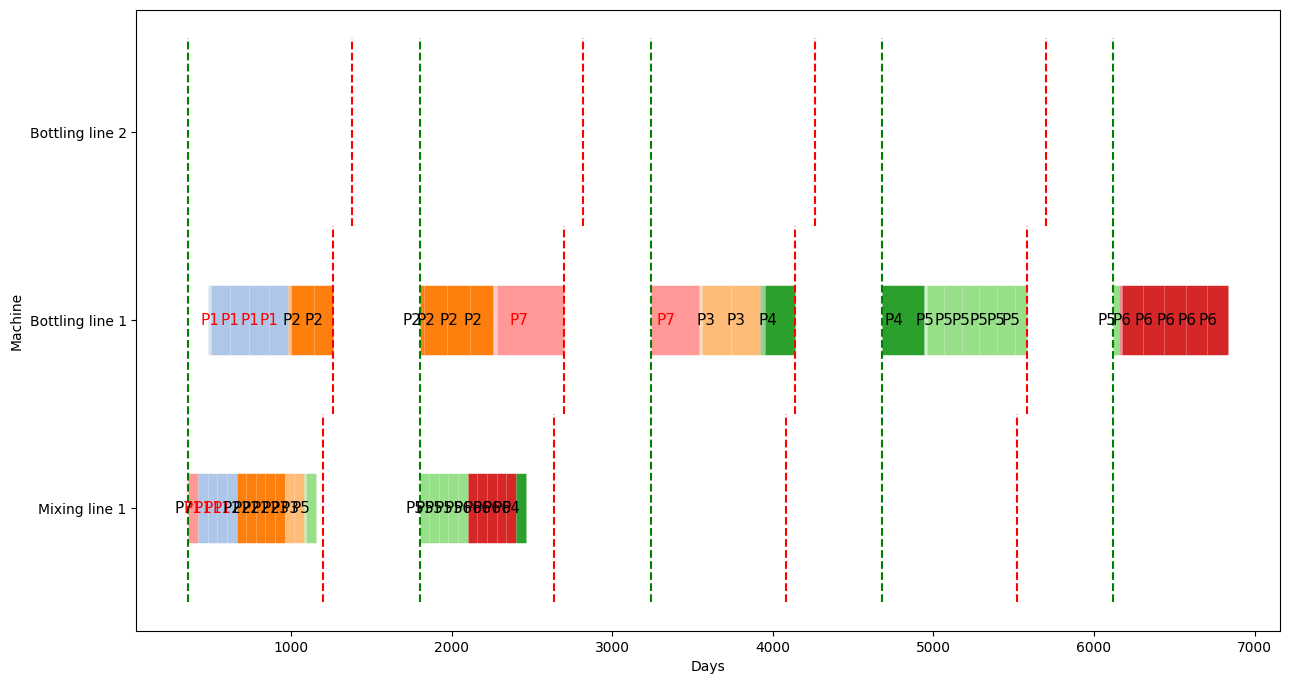

In [101]:
def test_tabu_search():
    # Create the JobShopProblem object
    job_shop_problem = JobShopProblem.from_data(data)
    
    # Run the Tabu Search algorithm
    scheduler = TabuSearchScheduler(job_shop_problem)
    best_schedule, best_value = scheduler.run()

    # Print the best schedule for debugging
    print("Best Schedule (Parallel):", best_schedule)

    # Visualize the best schedule directly
    job_shop_problem.visualize_schedule(best_schedule)

# Execute the test
test_tabu_search()